In [87]:
import xml.dom.minidom
import os
from tqdm import tqdm
import numpy as np
from pyrr import matrix44, Vector4, Vector3
from matplotlib import pyplot as plt 
from PIL import Image
import cv2
%matplotlib inline

In [130]:
# consts
MASTER = 'a_8_8c766163-d922-4a6a-9374-8a0abb788f41'
SCENE_FILE_MASTER = f'{MASTER}.xml'
DATA_SET_ROOT = '/home/ax/master/2019_02/masterThesis/DeepExplain/experiments/data/generated'
filename = f'{DATA_SET_ROOT}/{SCENE_FILE_MASTER}'
filename_mask = f'{DATA_SET_ROOT}/{MASTER}_mask.png'
filename_image = f'{DATA_SET_ROOT}/{MASTER}.jpg'


VERTICES = np.array([[1.0, 1.0, 0.0],
                    [1.0, -1.0, 0.0],
                    [-1.0, -1.0, 0.0],
                    [-1.0, 1.0, 0.0]],
                        dtype="float32")



FACES = np.array([[0, 1, 3],
                    [1, 2, 3]],
                    dtype="int32")

WINDOW_WIDTH, WINDOW_HEIGHT = 768, 576
w, h = 432, 368
# camera params
FAR_CLIP = 2500.0
NEAR_CLIP = 2.0
FOV = 45.0

ORIGIN = np.array([-4.21425, 105.008, 327.119], dtype="float32")
TARGET = np.array([-4.1969, 104.951, 326.12], dtype="float32")
UP = np.array([0.0, 1.0, 0.0], dtype="float32")

# RECT PARAMS
RECT_SCALE = Vector3([15.0, 30.0, 1.0])
RECT_TRANSLATE = Vector3([0.0, 110.0, 15.0])
image_mask = Image.open(filename_mask)
image_pose = cv2.imread(filename_image)

In [89]:
def get_xyz_angle(filename):
    if not os.path.isfile(filename):
        print('File does not exist')
        return

    doc = xml.dom.minidom.parse(filename)

    shape_node_rect = doc.getElementsByTagName('shape')[1]
    transform_node = shape_node_rect.getElementsByTagName('transform')[0]
    translation_node = transform_node.getElementsByTagName('translate')[1]
    rotation_node = transform_node.getElementsByTagName('rotate')[0]

    x = float(translation_node.getAttribute('x'))
    y = float(translation_node.getAttribute('y'))
    z = float(translation_node.getAttribute('z'))

    angle = float(rotation_node.getAttribute('angle'))
    print(f'using: x={x}, y={y}, z={z}, angle={angle}')
    return x,y,z, angle
def compute_mvp(translation, rotation):
        # model matrix is correct
        identity_matrix = np.identity(4)
        scale_matrix = np.transpose(matrix44.create_from_scale(RECT_SCALE))
        trans_matrix = np.transpose(matrix44.create_from_translation(RECT_TRANSLATE))
        rot_matrix = np.transpose(matrix44.create_from_y_rotation(np.radians(360.0 - rotation)))
        trans_matrix_cur = np.transpose(matrix44.create_from_translation(translation))

        model_matrix = identity_matrix
        model_matrix = np.matmul(model_matrix, trans_matrix_cur)
        model_matrix = np.matmul(model_matrix, rot_matrix)
        model_matrix = np.matmul(model_matrix, trans_matrix)
        model_matrix = np.matmul(model_matrix, scale_matrix)


        view_matrix = np.transpose(
            matrix44.create_look_at(
                ORIGIN,
                TARGET,
                UP
            )
        )

        proj_matrix = np.transpose(
            matrix44.create_perspective_projection(
                FOV,
                WINDOW_WIDTH / WINDOW_HEIGHT,
                NEAR_CLIP,
                FAR_CLIP
            )
        )
        cam_matrix = np.matmul(proj_matrix, view_matrix)
        m = np.matmul(cam_matrix, model_matrix)

        return np.transpose(m)
    
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect


In [88]:
x,y,z, angle = get_xyz_angle(filename)
mvp = compute_mvp(Vector3([x, y, z]), angle)

using: x=-95.7432967717578, y=0.0, z=-36.89965642513232, angle=33.76991887797284


In [90]:
pixel_coordinates = []

for vertex in VERTICES:
    homo_vertex = np.append(vertex, 1.0)
    # Transform the face into clip space.
    vertex_clip_space = np.matmul(np.transpose(mvp), homo_vertex)

    #  Apply perspective division.
    vertex_normalize_device_space = np.array([
        vertex_clip_space[0] / vertex_clip_space[3], 
        vertex_clip_space[1] / vertex_clip_space[3],
        vertex_clip_space[2] / vertex_clip_space[3],
        vertex_clip_space[3]]
    )

    # Transform the face into screen space.
    vertex_screen_space = np.array([
        np.floor(0.5 * WINDOW_WIDTH * (vertex_normalize_device_space[0] + 1.0)),
        # flip image 
        WINDOW_HEIGHT - np.floor(0.5 * WINDOW_HEIGHT * (vertex_normalize_device_space[1] + 1.0)),
        vertex_normalize_device_space[2],
        vertex_normalize_device_space[3]
    ])


    pixel_coordinates.append(vertex_screen_space[:2])

In [91]:
x = [pixel[0] for pixel in pixel_coordinates]
y = [pixel[1] for pixel in pixel_coordinates]

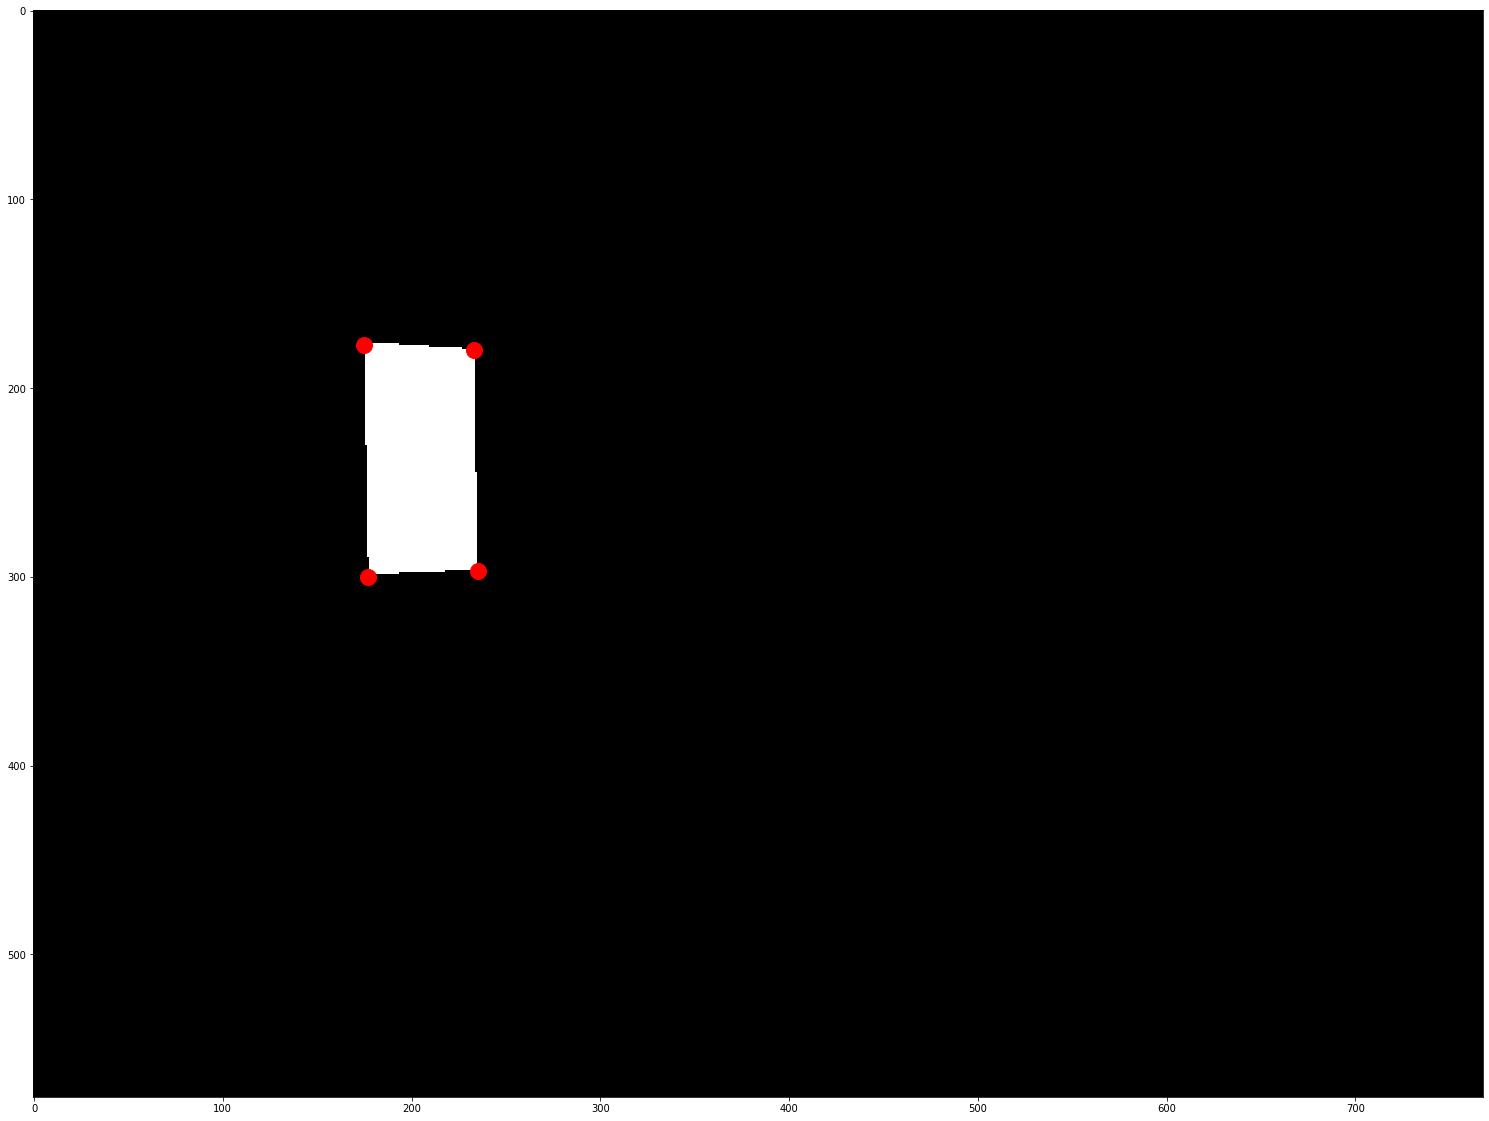

In [92]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image_mask)
ax.scatter(x,y,c='r',s=256) 

plt.show() 

(400, 200, 3)


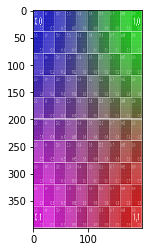

In [125]:
test_texture = cv2.imread('testBG.jpg')
plt.imshow(test_texture)
print(test_texture.shape)

In [131]:
maxHeight, maxWidth = test_texture.shape[:2]
src = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
dst = order_points(np.array(pixel_coordinates))
# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(src, dst)
print(M)
print(M.shape)
warped = cv2.warpPerspective(test_texture, M, (w, h))
print(M.dtype)

[[ 3.51448053e-01  4.22876980e-03  1.75000000e+02]
 [ 6.14201751e-02  3.06942267e-01  1.77000000e+02]
 [ 2.57471101e-04 -4.42803121e-06  1.00000000e+00]]
(3, 3)
float64


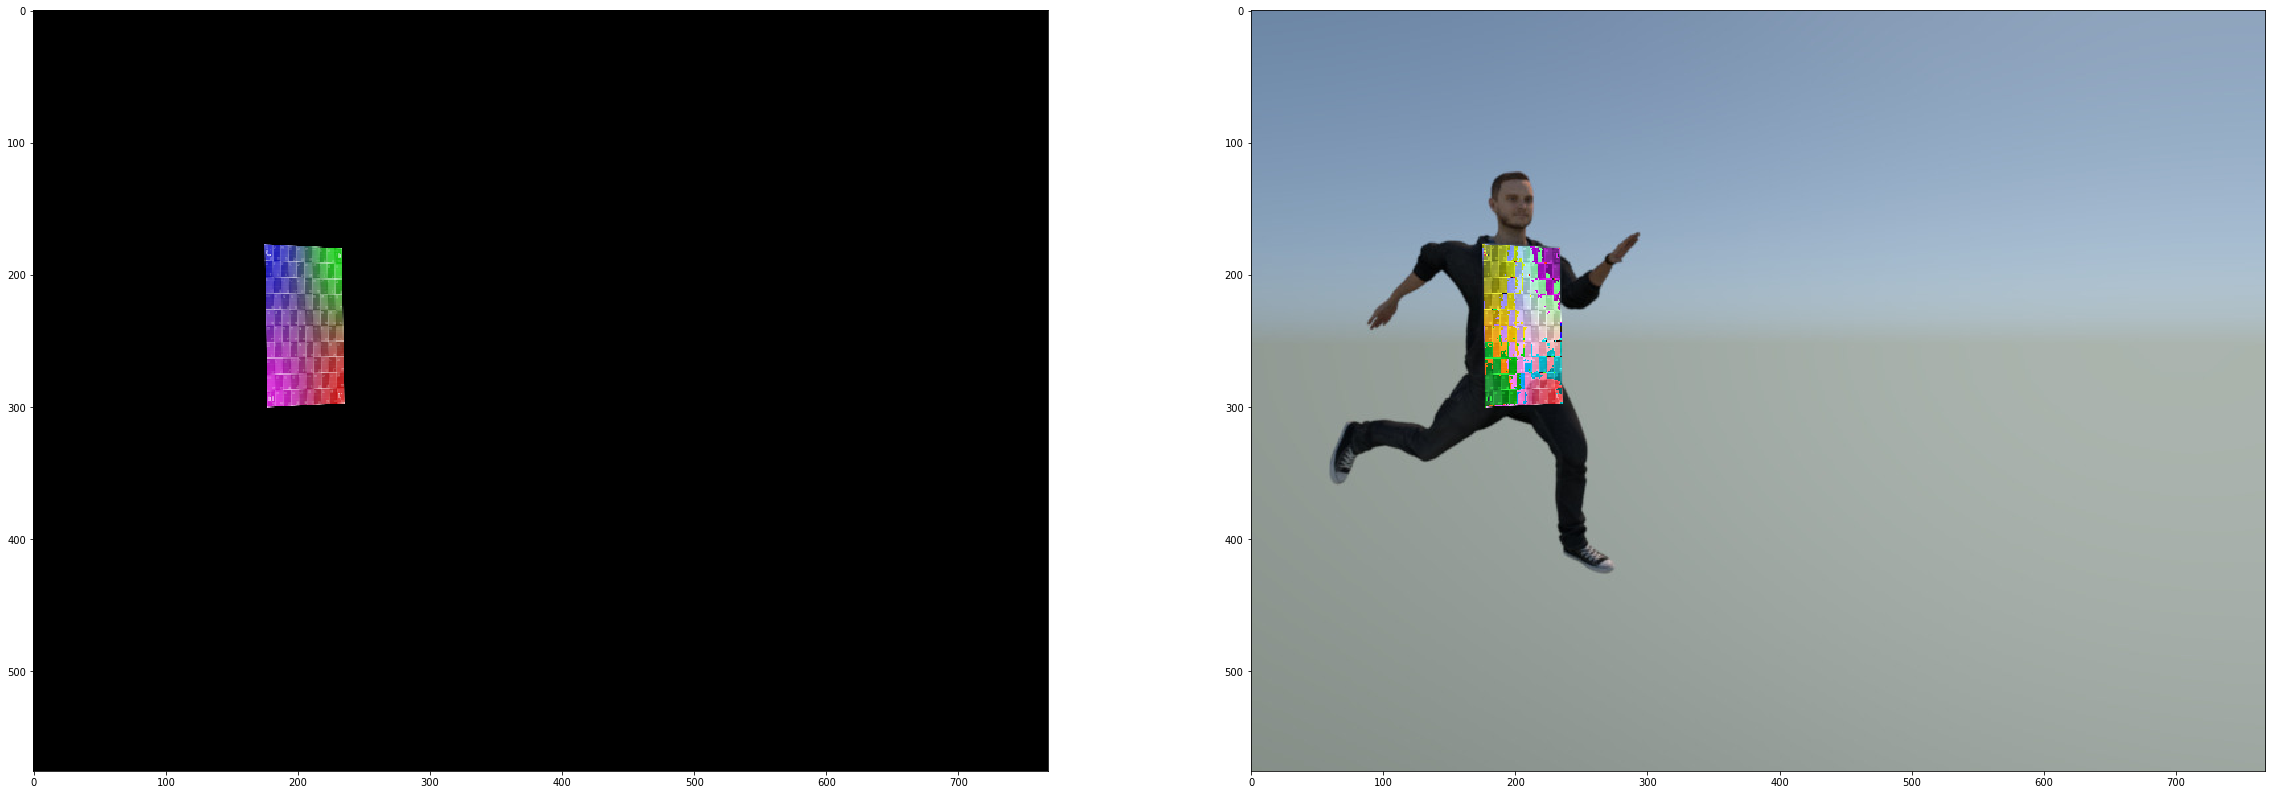

In [127]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(warped)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB) + warped)

plt.show() 

In [129]:
gl_format = np.transpose(np.array(M.flatten()[:-1], dtype=np.float32)[:,np.newaxis])
print(gl_format.shape)
print(gl_format)

(1, 8)
[[ 3.5144806e-01  4.2287698e-03  1.7500000e+02  6.1420176e-02
   3.0694225e-01  1.7700000e+02  2.5747111e-04 -4.4280314e-06]]
